# Kristijono Donelaičio 'Metų' hegzametras

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tabulate
from  matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")

def write_table(df, the_name):
    with open(f"tables/{the_name}.tex", "w") as f:
        f.write(df.style.to_latex())

In [2]:
all_caesuras = ["3h", "5h", "ktt", "7h", "pqt", "bd"]
!mkdir -p figures tables
df = pd.read_csv("metai/metai-scansion.csv")

In [3]:
incorrect_lines = df[df.isnull()["scansion"]]
df = df.dropna()

In [4]:
ambiguous = df["scansion"].str.contains(r'\|')
ambiguous_lines = df[ambiguous]
df = df[~ambiguous]

In [5]:
# convert data types
df["scansion"] = pd.Categorical(df["scansion"], sorted(df["scansion"].drop_duplicates().values, key=lambda x: x[::-1]))

for caesura in all_caesuras:
    df[caesura] = df[caesura].map({"True": True, "False": False})

for column in ["stressConflict", "metreConflict", "weightConflict", "syllables", "words"]:
    df[column] = df[column].astype(int)

## How well does the analysis match the syllables?

In [42]:
conflicts = df[["metreConflict", "stressConflict", "weightConflict"]].apply(pd.Series.value_counts)
write_table(conflicts, "conflics")
conflicts

,metreConflict,stressConflict,weightConflict
0,2920.0,2219.0,853
1,32.0,668.0,1084
2,NaN,56.0,701
3,NaN,9.0,239
4,NaN,NaN,60
5,NaN,NaN,14
6,NaN,NaN,1


In [23]:
# df["weightConflict"].astype(int).value_counts()
df[(df["weightConflict"] > 3) | (df["stressConflict"] > 2)][["book", "verse", "text"]]

,book,verse,text
53,1,54,ogĭ trŏbà vissà vissùr iškrypŭsĭ ròdės;
57,1,58,o găspădinnė jo pûstynes mandăgey̆ lópė.
133,1,134,"tù nè lúbiji pyragû neigĭ răgaišiû,"
193,1,194,àr sù próvita pučkà tikt mùšă tĭkt mùša-
231,1,232,bèt dâr tai nĕ gănà; jis viss pĭnnį̆gu ...
...,...,...,...
2687,4,402,"tù, tărė̆ prìčkus jám, saugókis kàspăr..."
2770,4,485,dievs ant sósto prakilnaùs tav pàliĕpė̆ s...
2820,4,535,ìr mus álų sù gvoltù jau vìsą̆ sŭgėrę
2885,4,600,àliĕ sŭ vienă dienà žiedélis dár nĕsĭ...


## Amount of syllables

In [40]:
# syll / words
syls_per_words = (df.groupby("book")["syllables"].sum() / df.groupby("book")["words"].sum()).rename("words / syllable")
average_sylls = df.groupby("book")["syllables"].mean().rename("μ syllables")
stddev_sylls = df.groupby("book")["syllables"].std().rename("σ syllables")
df_syllables = pd.concat([syls_per_words, average_sylls, stddev_sylls], axis=1)
write_table(df_syllables, "syllables")
df_syllables

,words / syllable,μ syllables,σ syllables
book,,,
1,1.965188,13.551988,0.688711
2,1.973749,13.487288,0.652366
3,2.025509,13.452145,0.609369
4,1.982945,13.487518,0.646420


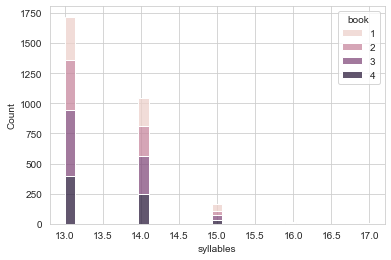

In [63]:
# syllable count histogram
sns.histplot(x="syllables", data=df, hue="book", multiple="stack")
plt.savefig("figures/syllable-count-histogram.svg")

## Scansion

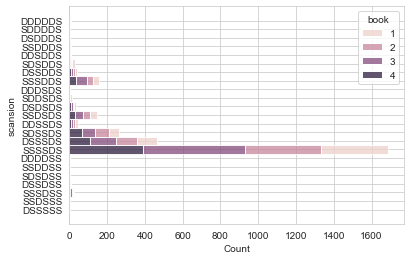

In [64]:
sns.histplot(y="scansion", data=df, hue="book", multiple="stack")
plt.savefig("figures/scansion-histogram.svg")

In [13]:
pd.crosstab(df['scansion'], df['syllables'])

syllables,13,14,15,16,17
scansion,,,,,
DDDDDS,0,0,0,0,6
SDDDDS,0,0,0,1,0
DSDDDS,0,0,0,5,0
SSDDDS,0,0,10,0,0
DDSDDS,0,0,0,7,0
SDSDDS,0,0,27,0,0
DSSDDS,0,0,39,0,0
SSSDDS,0,157,0,0,0
DDDSDS,0,0,0,1,0


In [44]:
strange_verses = df[df["scansion"].str.endswith("SSS")][["book", "verse", "text", "scansion"]]
write_table(strange_verses, "strange-verses")
strange_verses

,book,verse,text,scansion
1087,2,428,"iómarke brangvyno stuopą vìssą nŭrijęs,",DSSSSS
1118,2,459,"ik paskiáus iš pápykio beržinnį păgávęs,",SSDSSS
1693,3,320,"àr nĕsĭbìjotės užsprìngt, kad kábĭăr ...",DSSSSS
2418,4,133,ìr kitiems baudžáuninkams tikt gėdą pădáro.,SSDSSS


## Caesurae

### Caesuras per book

In [15]:
caesura_rows = []
for index, row in df.iterrows():
    for caesura in all_caesuras:
        if row[caesura] == True:
            caesura_rows.append([row["book"], row["verse"], caesura])
caesura_df = pd.DataFrame(caesura_rows, columns=["book", "verse", "caesura"])
caesura_df["caesura"] = pd.Categorical(caesura_df["caesura"], all_caesuras)

In [54]:
caesura_per_book = pd.crosstab(caesura_df["book"], caesura_df["caesura"])
write_table(caesura_per_book, "caesura-per-book")
caesura_per_book

caesura,3h,5h,ktt,7h,pqt,bd
book,,,,,,
1,380,492,11,394,10,387
2,395,548,8,430,11,392
3,525,703,6,549,9,514
4,372,530,4,430,10,372


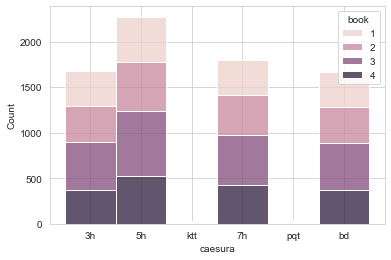

In [65]:
sns.histplot(x="caesura", data=caesura_df, hue="book", multiple="stack")
plt.savefig("figures/caesura-histogram.svg")

In [55]:
reslut = []
for s in all_caesuras:
    count = df[s].value_counts()[True]
    reslut.append([s, count, count / len(df)])
caesura_count = pd.DataFrame(reslut, columns=["Caesura", "Count", "Frequency"])
write_table(caesura_count, "caesura-count")
caesura_count


,Caesura,Count,Frequency
0,3h,1672,0.566396
1,5h,2273,0.769986
2,ktt,29,0.009824
3,7h,1803,0.610772
4,pqt,40,0.013550
5,bd,1665,0.564024


### Caesura-less lines

In [67]:
caesuraless = df[~df["3h"] & ~df["5h"] & ~df["ktt"] & ~df["7h"] & ~df["pqt"] & ~df["bd"]]
write_table(caesuraless, "caesuraless")
caesuraless

,book,verse,text,words,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
1009,2,350,"taip, kàd klápai vyžu viežlibay pădărytû,",6,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,×––⏑×××××⏑⏑⏑–,1,––––⏑⏑–⏑–⏑⏑⏑–,2
1307,2,648,irgĭ kănápės vėjû parblôkštos svĭrĭne...,5,14,DSSSDS,False,False,False,False,False,False,×⏑⏑×××××××⏑⏑××,0,××⏑–⏑⏑–⏑–⏑××××,3,–⏑⏑–––––––⏑⏑–⏑,0
1485,3,112,"ir į sávŏ nămélį viezlibaý sŭvădìnęs,",6,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,××–⏑⏑–⏑⏑⏑–⏑⏑–⏑,1,–––⏑⏑–––⏑–⏑⏑⏑–,1
1538,3,165,"bèt, kaip pónai dáro, tranšieruot nĕmŏkė...",6,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,–×–⏑–⏑×××××××,0,–––––⏑–––⏑⏑––,0
2087,3,714,"bártis, ìrgĭ nĕšvánkey kóliotis ŭssĭma...",5,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,–⏑–⏑⏑–⏑–⏑⏑⏑⏑–⏑,1,–––⏑⏑––––––⏑––,1
2161,3,788,"ìr puikióku kùrpiu gėdėjos pămĭnėti,",5,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,–⏑–⏑–⏑×××××××,0,–––⏑–––––⏑⏑–⏑,0
2602,4,317,bèt ir dùrăką̆ pùloks pérplyšdams păgă...,6,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,–×–⏑⏑–⏑–⏑⏑⏑⏑–⏑,1,––⏑⏑–⏑––⏑–⏑⏑⏑⏑,4


### Caesura co-occurrences

In [58]:
from itertools import product
caesura_count = len(all_caesuras)
occurrences = np.zeros((caesura_count+1, caesura_count+1))
matrix = np.zeros((caesura_count))
for idx, row in df[all_caesuras].iterrows():
    for c1 in all_caesuras:
        if row[c1] and not any(row[c2] for c2 in all_caesuras if c2 != c1):
            i = all_caesuras.index(c1)
            matrix[i] += 1
    for c1, c2 in product(all_caesuras, all_caesuras):
        if c1 == c2:
            continue
        i1, i2 = all_caesuras.index(c1), all_caesuras.index(c2)
        if row[c1] and row[c2]:
            occurrences[i1, i2] += 1
occurrences[-1,:-1] = matrix
occurrences[:-1,-1] = matrix
occurrences = occurrences.astype(int)
df_occ = pd.DataFrame(occurrences, index=all_caesuras + ["alone"], columns=all_caesuras + ["alone"])

In [60]:
write_table(df_occ, "cooccurrences")
df_occ

,3h,5h,ktt,7h,pqt,bd,alone
3h,0,1199,10,987,22,978,19
5h,1199,0,6,1216,19,1419,56
ktt,10,6,0,17,0,16,1
7h,987,1216,17,0,14,667,116
pqt,22,19,0,14,0,0,5
bd,978,1419,16,667,0,0,6
alone,19,56,1,116,5,6,0


\begin{tabular}{lrrrrrrr}
\hline
 3h    &    0 & 1199 & 10 &  987 & 22 &  978 &  19 \\
 5h    & 1199 &    0 &  6 & 1216 & 19 & 1419 &  56 \\
 ktt   &   10 &    6 &  0 &   17 &  0 &   16 &   1 \\
 7h    &  987 & 1216 & 17 &    0 & 14 &  667 & 116 \\
 pqt   &   22 &   19 &  0 &   14 &  0 &    0 &   5 \\
 bd    &  978 & 1419 & 16 &  667 &  0 &    0 &   6 \\
 alone &   19 &   56 &  1 &  116 &  5 &    6 &   0 \\
\hline
\end{tabular}